In [51]:
# import packages
import pandas as pd
import numpy as np
import torch, re, math
from sklearn.model_selection import train_test_split

from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from binary_trainer import BinaryTrainer

In [52]:
df = pd.read_csv(r'D:\Python_Projects\Vector\archive\synthetic_fraud_dataset.csv', parse_dates=['Timestamp'])
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


In [53]:
import matplotlib.pyplot as plt

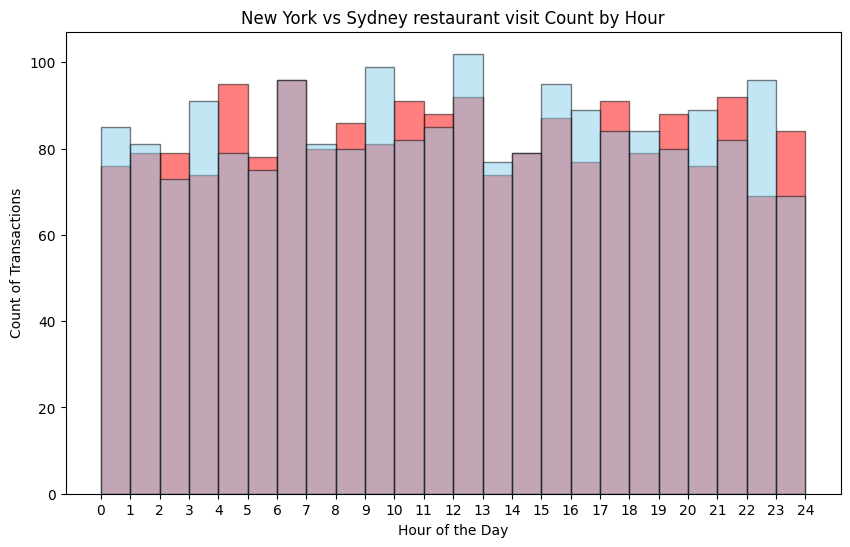

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df[(df['Location']=='New York')&(df['Merchant_Category']=='Restaurants')]['Timestamp'].dt.hour, bins=24, range=(0, 24), color='red', edgecolor='black', alpha=0.5)
plt.hist(df[(df['Location']=='Sydney')&(df['Merchant_Category']=='Restaurants')]['Timestamp'].dt.hour, bins=24, range=(0, 24), color='skyblue', edgecolor='black', alpha=0.5)
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Transactions')
plt.title('New York vs Sydney restaurant visit Count by Hour')
plt.xticks(range(0, 25))
plt.show()

# data set is a little too synthetic

In [56]:
### Sine transformation for dates:
def sine_transform(dt):
    '''
    Transform timestamps to between [0,1]. Midnight-> 0; noon-> 1; Morning ->0
    Transform months to between [0,1]. January -> 0
    '''
    # Convert time stamp into sine wave
    seconds_since_midnight = dt.hour * 3600 + dt.minute * 60 + dt.second 
    day_fraction = seconds_since_midnight / (24 * 3600)
    day_output = (math.sin(2 * math.pi * day_fraction - math.pi/2) + 1) / 2

    # Compute year_output
    year = dt.year
    jan1 = datetime(year, 1, 1)
    jan1_next = datetime(year + 1, 1, 1)
    total_days = (jan1_next - jan1).days
    day_of_year = (dt - jan1).days + 1
    year_fraction = (day_of_year - 1) / (total_days - 1)
    year_output = (math.sin(math.pi * year_fraction - math.pi/2) + 1) / 2

    return day_output, year_output

In [57]:
df[['day','year']]= df['Timestamp'].apply(lambda x: pd.Series(sine_transform(x)))

In [58]:
sine_transform(datetime(2025, 12, 31,1,0))

(0.017037086855465844, 1.0)

In [50]:
# check types of categorical variables:
categorical_variables = {col: df[col].nunique() for col in df.select_dtypes(include=['object', 'category']).columns}

{'Transaction_ID': 50000,
 'User_ID': 8963,
 'Transaction_Type': 4,
 'Device_Type': 3,
 'Location': 5,
 'Merchant_Category': 5,
 'Card_Type': 4,
 'Authentication_Method': 4}

In [59]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Filter columns based on the number of unique values
cols_to_encode = [col for col in categorical_cols if df[col].nunique() < 10]

# Drop columns with 10 or more unique values
df = df.drop(columns=[col for col in categorical_cols if df[col].nunique() >= 10])

# Perform one-hot encoding on the selected columns
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Transaction_Amount              50000 non-null  float64       
 1   Timestamp                       50000 non-null  datetime64[ns]
 2   Account_Balance                 50000 non-null  float64       
 3   IP_Address_Flag                 50000 non-null  int64         
 4   Previous_Fraudulent_Activity    50000 non-null  int64         
 5   Daily_Transaction_Count         50000 non-null  int64         
 6   Avg_Transaction_Amount_7d       50000 non-null  float64       
 7   Failed_Transaction_Count_7d     50000 non-null  int64         
 8   Card_Age                        50000 non-null  int64         
 9   Transaction_Distance            50000 non-null  float64       
 10  Risk_Score                      50000 non-null  float64       
 11  Is

In [61]:
y_data=list(df['Fraud_Label'])
x_data = df.drop(columns=['Timestamp','Fraud_Label'])
len(list(x_data.columns))

32

In [65]:
## Create Model

class SimpleMLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, dropout_rate=0.1):
        """
        Inputs:
            input_dim (int): Number of input features
            hidden_dim (int): Size of the hidden layer

        Since I am using BCELosswithLogits, there is no signoid activation at the end to convert logits into a probability between [0, 1]
        probabilities = torch.sigmoid(logits) to convert output logits into probabilities.
        use torch.argmax(logits) or interpret the probabilities directly to get class labels
        """
        super(SimpleMLPClassifier, self).__init__()
        
        # First fully connected layer (input → hidden)
        self.hidden_1 = nn.Linear(input_dim, hidden_dim)
        
        # Batch normalization layer to normalize activations
        self.bnorm_1 = nn.BatchNorm1d(hidden_dim)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Output layer (hidden → 1)
        self.output = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        """
        torch.tensor (input shape: [batch_size, input_dim]) -> torch.tensor (output logits shape: [batch_size, 1])

        """
        # First layer with ReLU activation and batch normalization
        x = self.hidden_1(x)
        x = self.bnorm_1(x)
        x = F.relu(x)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Output layer (no signoid activation as we'll use BCEWithLogitsLoss)
        x = self.output(x)
        
        return x


# train with custom trainer object
def train_and_evaluate(x_data, y_data, test_size=0.2, val_size=0.2, random_state=42):
    """
    
    """
    # Split into train and test
    x_temp, x_test, y_temp, y_test = train_test_split(
        x_data, y_data, test_size=test_size, random_state=random_state, stratify=y_data
    )
    
    # Split training data into train and validation
    x_train, x_val, y_train, y_val = train_test_split(
        x_temp, y_temp, test_size=val_size, random_state=random_state, stratify=y_temp
    )
    
    # Standardize features
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_val_scaled = scaler.transform(x_val)
    x_test_scaled = scaler.transform(x_test)
    
    # Create the model
    input_dim = x_train.shape[1]
    model = SimpleMLPClassifier(input_dim=input_dim, hidden_dim=32, dropout_rate=0.1)
    
    # Initialize trainer
    trainer = BinaryTrainer(
        model=model,
        x_train=x_train_scaled,
        y_train=y_train,
        x_val=x_val_scaled,
        y_val=y_val,
        batch_size=128,
        epochs=100,
        learning_rate=0.001,
        model_save_path='best_mlp_model.pth'
    )
    
    # Train model
    best_model, history = trainer.train()
    
    # Evaluate on test set
    test_metrics = trainer.evaluate(x_test_scaled, y_test)
    
    return best_model, history, test_metrics

In [63]:
best_model, history, test_metrics = train_and_evaluate(x_data, y_data)


Epoch 1/100
Validation Batch 79/79, Validation Loss: 0.4503
Epoch 1/100 - Train Loss: 0.4825, Val Loss: 0.3660, F1 Macro: 0.7930
Model saved to best_mlp_model.pth

Epoch 2/100
Validation Batch 79/79, Validation Loss: 0.2871
Epoch 2/100 - Train Loss: 0.3145, Val Loss: 0.2573, F1 Macro: 0.8889
Model saved to best_mlp_model.pth

Epoch 3/100
Validation Batch 79/79, Validation Loss: 0.1913
Epoch 3/100 - Train Loss: 0.2286, Val Loss: 0.1808, F1 Macro: 0.9444
Model saved to best_mlp_model.pth

Epoch 4/100
Validation Batch 79/79, Validation Loss: 0.1399
Epoch 4/100 - Train Loss: 0.1824, Val Loss: 0.1390, F1 Macro: 0.9638
Model saved to best_mlp_model.pth

Epoch 5/100
Validation Batch 79/79, Validation Loss: 0.1316
Epoch 5/100 - Train Loss: 0.1524, Val Loss: 0.1158, F1 Macro: 0.9730
Model saved to best_mlp_model.pth

Epoch 6/100
Validation Batch 79/79, Validation Loss: 0.1182
Epoch 6/100 - Train Loss: 0.1367, Val Loss: 0.0975, F1 Macro: 0.9772
Model saved to best_mlp_model.pth

Epoch 7/100
Val

In [66]:
test_metrics

{'test_loss': 0.03400207940441898,
 'accuracy': 0.9933,
 'f1_score': 0.9923307594637141}

In [68]:
best_model

SimpleMLPClassifier(
  (hidden_1): Linear(in_features=32, out_features=32, bias=True)
  (bnorm_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

In [107]:
class TorchPipeline():
    def __init__(self, model, x_data = x_data):
        self.model = model
        self.scaler = StandardScaler().fit(x_data)

    def predict(self, X):
        X = self.scaler.transform(X)
        X = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            logits = self.model(X)
        probability = torch.sigmoid(logits).numpy().flatten()
        prediction  = np.where(probability >= 0.5, 1, 0)
        return {'class': prediction, 'probability': probability}
        
        
        

In [108]:
pipe = TorchPipeline(best_model)

In [109]:
pipe.predict(x_data)['class']

array([0, 1, 1, ..., 0, 1, 1])